### Imports

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
from pathlib import Path
scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

In [12]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.feature_extraction import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from Pipeline.pre_processing_pipeline import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import preprocessing_config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

### Loading the data

In [45]:
# temp_pipeline = PreProcessingPipelineTemporal()

In [46]:
# train_fn, dataloader_train = temp_pipeline.get_processed_trainloader(64, 'indexbands', vi_type='msi')

Train

In [47]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
non_temporal_images = get_non_temporal_images(border_removed_images_train)
field_numbers, refined_images_train = refine_chanel_non_temporal(non_temporal_images)

len(refined_images_train), refined_images_train[0].shape

(2425, (64, 64, 6))

Test

In [48]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
border_removed_images = blacken_field_borders_temporal(temporal_images_test)
non_temporal_images_test = get_non_temporal_images(border_removed_images)
field_numbers_test, refined_images_test = refine_chanel_non_temporal(non_temporal_images_test)

(len(refined_images_test), refined_images_test[0].shape)

(48, (64, 64, 6))

In [49]:
image_tensor_train = np.stack(refined_images_train)  # Shape: (N x 64 x 64 x 6)
image_tensor_test = np.stack(refined_images_test)   # Shape: (N x 64 x 64 x 6)

Data Loaders

In [50]:
batch_size = 64
dataloader_train = create_data_loader(image_tensor_train, field_numbers, batch_size=batch_size, shuffle=True)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([64, 6, 64, 64])
Batch Field Numbers: ('1183261.0_1187442.0_1187447.0_1187450.0', '1177174.0', '1217091.0', '1221835.0', '1183994.0', '1227993.0', '1226918.0', '1219185.0', '1194875.0_1218145.0', '1225191.0', '1228815.0', '1223750.0', '1223843.0', '1175475.0', '1194782.0_1194784.0', '1217805.0', '1234246.0', '1216226.0', '1227660.0', '1224407.0', '1224233.0_1224234.0', '1217950.0_1217951.0', '1225953.0_1233549.0', '921', '1185838.0', '1168656.0', '1219481.0', '1225441.0', '1218154.0', '1224285.0_1224311.0', '1194682.0_1194694.0_1217787.0', '1195605.0', '1169566.0_1221181.0', '1167526.0_1167528.0_1167529.0', '1227723.0', '1222630.0_1222635.0_1234669.0', '1222138.0', '1172749.0_1224164.0', '1224929.0', '1189634.0', '1187755.0', '1187726.0', '1840', '1223216.0', '1222662.0_1227727.0', '1225888.0', '1226232.0', '1216591.0_1216593.0_1216595.0', '1168522.0', '1217364.0', '1217956.0', '1194503.0', '1220437.0', '1169469.0', '1175125.0', '1171720.0', '1226197.0', 

In [51]:
batch_size = 64
dataloader_test = create_data_loader(image_tensor_test, field_numbers_test, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_test:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([48, 6, 64, 64])
Batch Field Numbers: ('1168039.0', '1228889.0', '1168663.0_1176271.0', '1168692.0_1220431.0', '1171179.0_1222688.0', '5', '1172001.0_1225692.0', '1174805.0', '1176318.0', '1176365.0', '1177274.0', '1177490.0', '1177490.0_1183928.0', '1178038.0', '1178198.0_1225298.0', '1179855.0_1187336.0', '1182776.0', '1182822.0_1216964.0', '1183171.0', '1194806.0_1194808.0', '1196327.0', '1196347.0', '1196489.0_1196747.0', '1216230.0_1219006.0', '1216239.0', '1216250.0', '1216801.0_1216804.0', '1217032.0', '1217498.0', '1219929.0_1219932.0', '1220322.0', '1222641.0', '1223341.0', '1223970.0', '1224018.0', '1224356.0', '1225081.0', '1225397.0', '1225547.0', '1225592.0', '1226125.0', '1226225.0', '1226904.0_1227074.0', '1227071.0', '1227321.0_1229711.0', '1227495.0', '1227663.0', '1230818.0')


### Modeling

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_size):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 32x32
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 16x16
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # 8x8
            nn.Flatten(),
            nn.Linear(in_features=512 * 8 * 8, out_features=latent_size)  # Ensure correct flattening size
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=512 * 8 * 8),  # Correct for latent size
            nn.ReLU(),
            nn.Unflatten(1, (512, 8, 8)),  # Unflatten back to (256, 8, 8)
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output size: 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output size: 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output size: 64x64
            nn.Sigmoid()  
        )

    def forward(self, x):
        z = self.encoder(x)  
        x_reconstructed = self.decoder(z)  
        return z, x_reconstructed


In [53]:
# class AutoEncoder(nn.Module):
#     def __init__(self, in_channels, latent_size):
#         super(AutoEncoder, self).__init__()
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, stride=2),
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, stride=2), 
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, stride=2),
#             nn.Flatten(),                                             
#             nn.Linear(in_features=512 * 8 * 8, out_features=latent_size)   
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=latent_size, out_features=512 * 8 * 8),  
#             nn.ReLU(),
#             nn.Unflatten(1, (512, 8, 8)),
#             nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),        
#             nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),            
#             nn.ConvTranspose2d(in_channels=128, out_channels=in_channels, kernel_size=3, stride=2, padding=1),
#             nn.Sigmoid()                                              
#         )
        
#     def forward(self, x):
#         z = self.encoder(x)
#         x = self.decoder(z)
#         return z, x

In [61]:
model = AutoEncoder(6,1024)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(6, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=1024, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=32768, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(512, 8, 8))
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(256, 128,

In [62]:
# Train
device = 'mps'
epochs = 3
lr = 0.0001

device = torch.device(device)  
model.to(device)
trained_model, epoch_losses = train_model_ae(model, dataloader_train, epochs=epochs, lr=lr, device=device)

Epoch 1/3, Loss: 0.0966
Epoch 2/3, Loss: 0.0010
Epoch 3/3, Loss: 0.0010


In [63]:
# plot_losses(epoch_losses)

In [64]:
# torch.save(trained_model.state_dict(), config.trained_models_path + "autoencoder_6bands.pth")

### Load Saved Model

In [65]:
# model.load_state_dict(torch.load(config.trained_models_path + "autoencoder_6bands.pth"))
# model.eval()

In [66]:
# Extract features and field numbers
train_features, fno_train = extract_features_ae(trained_model, dataloader_train, device)
test_features, fno_test = extract_features_ae(trained_model, dataloader_test, device)

# Apply K-means clustering
kmeans = apply_kmeans(train_features, n_clusters=2, random_state=56)
train_predictions = kmeans.labels_
test_predictions = kmeans.predict(test_features.cpu().numpy())


/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Evaluation

In [67]:
test_gt_aligned, test_pred_aligned = get_gt_and_pred_aligned(field_numbers_test, test_predictions, config.labels_path)

test_metrics = evaluate_clustering_metrics(test_gt_aligned, test_pred_aligned)
test_metrics

{'Accuracy': 0.5737704918032787,
 'Adjusted Rand Index (ARI)': 0.004471598177883523,
 'Normalized Mutual Information (NMI)': 0.04740782631335531,
 'Fowlkes-Mallows Index (FMI)': 0.5472491537328785}

## Vegetation Indices Experiments

### Loading

In [5]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)

# field_numbers, indices_images = indexbands_temporal_cubes(border_removed_images_train, 'msi')
field_numbers, indices_images = multiple_indices_bands_temporal_cubes(border_removed_images_train)
non_temporal_images = get_non_temporal_images(indices_images)
refined_images_train = non_temporal_images
len(refined_images_train), refined_images_train[0].shape

(2425, (64, 64, 8))

In [6]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
border_removed_images_test = blacken_field_borders_temporal(temporal_images_test)

# field_numbers_test, indices_images_test = indexbands_temporal_cubes(border_removed_images_test, 'msi')
field_numbers_test, indices_images_test = multiple_indices_bands_temporal_cubes(border_removed_images_test)
non_temporal_images_test = get_non_temporal_images(indices_images_test)
refined_images_test = non_temporal_images_test
(len(refined_images_test), refined_images_test[0].shape)

(48, (64, 64, 8))

In [7]:
image_tensor_train = np.stack(refined_images_train)  # Shape: (N x 64 x 64 x 3)
image_tensor_test = np.stack(refined_images_test)   # Shape: (N x 64 x 64 x 3)

Data Loaders

In [8]:
batch_size = 64
dataloader_train = create_data_loader(image_tensor_train, field_numbers, batch_size=batch_size, shuffle=True)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([64, 8, 64, 64])
Batch Field Numbers: ('1216668.0', '1217126.0', '1223911.0', '1224423.0', '1182826.0_1184692.0', '1177568.0_1177571.0', '1216543.0', '1178844.0', '1221809.0', '1229486.0', '1224015.0', '457', '1217796.0_1217811.0', '1183995.0', '1223545.0', '1220413.0', '1216897.0', '1224148.0_1224474.0', '1183177.0_1219174.0_1224376.0', '1171161.0_1219438.0', '1167627.0', '511', '1217797.0', '1196368.0_1219472.0_1225937.0', '1226373.0_1227574.0', '1227958.0', '1224171.0', '1220323.0', '1222370.0', '1178316.0', '1186343.0', '1221070.0', '1223146.0', '1224087.0', '1168146.0', '1223509.0', '1230841.0', '1226300.0', '1168348.0', '1217458.0_1217459.0_1217460.0', '1195768.0', '1222222.0', '1172757.0_1184691.0', '1187755.0', '1217339.0', '1217892.0', '1217086.0', '1224935.0', '1623', '1169469.0', '1182682.0', '1223825.0', '1217919.0', '1193980.0', '1222477.0', '1169823.0', '1175022.0', '1218982.0', '1229761.0', '1219689.0_1223637.0_1223693.0_1223709.0_1223746.0

In [9]:
batch_size = 64
dataloader_test = create_data_loader(image_tensor_test, field_numbers_test, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_test:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([48, 8, 64, 64])
Batch Field Numbers: ('1168039.0', '1228889.0', '1168663.0_1176271.0', '1168692.0_1220431.0', '1171179.0_1222688.0', '5', '1172001.0_1225692.0', '1174805.0', '1176318.0', '1176365.0', '1177274.0', '1177490.0', '1177490.0_1183928.0', '1178038.0', '1178198.0_1225298.0', '1179855.0_1187336.0', '1182776.0', '1182822.0_1216964.0', '1183171.0', '1194806.0_1194808.0', '1196327.0', '1196347.0', '1196489.0_1196747.0', '1216230.0_1219006.0', '1216239.0', '1216250.0', '1216801.0_1216804.0', '1217032.0', '1217498.0', '1219929.0_1219932.0', '1220322.0', '1222641.0', '1223341.0', '1223970.0', '1224018.0', '1224356.0', '1225081.0', '1225397.0', '1225547.0', '1225592.0', '1226125.0', '1226225.0', '1226904.0_1227074.0', '1227071.0', '1227321.0_1229711.0', '1227495.0', '1227663.0', '1230818.0')


### Modeling

In [36]:
in_channels = 8
latent_size = 50
device = 'mps'
epochs = 10
lr = 0.001

In [37]:
# Train
model = AutoEncoder(in_channels,latent_size)
device = torch.device(device)
model.to(device)
trained_model_vi1, epoch_losses = train_model_ae(model, dataloader_train, epochs=epochs, lr=lr, device=device)

Epoch 1/10, Loss: 0.0294
Epoch 2/10, Loss: 0.0137
Epoch 3/10, Loss: 0.0137
Epoch 4/10, Loss: 0.0137
Epoch 5/10, Loss: 0.0137
Epoch 6/10, Loss: 0.0137
Epoch 7/10, Loss: 0.0137
Epoch 8/10, Loss: 0.0137
Epoch 9/10, Loss: 0.0137
Epoch 10/10, Loss: 0.0137


In [38]:
epoch_losses

[0.029356421951792742,
 0.013685725114651416,
 0.013682076364363494,
 0.013675623940990159,
 0.013680370720593553,
 0.013686802826429667,
 0.013676879657922606,
 0.01368790127238945,
 0.013690707714934098,
 0.013677561189979315]

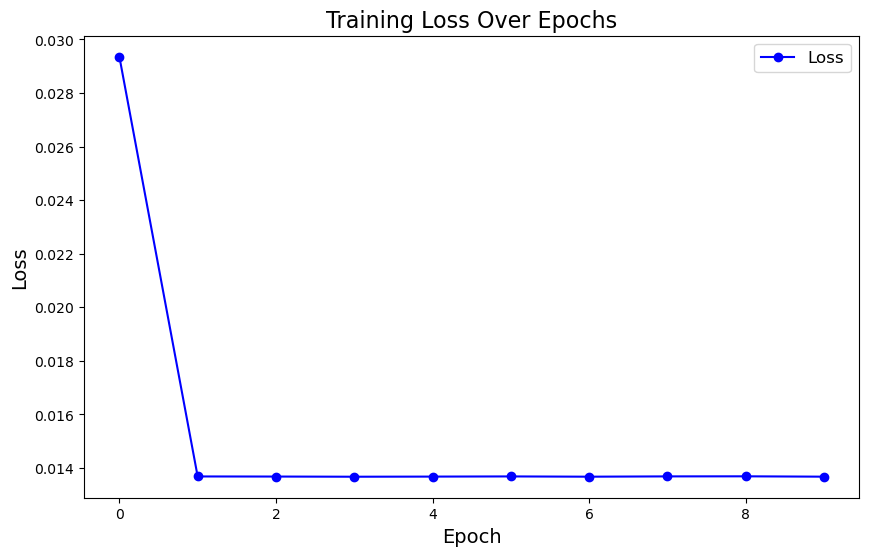

In [39]:
plot_losses(epoch_losses)

### Save + Load

In [13]:
torch.save(trained_model_vi.state_dict(), config.trained_models_path + "autoencoder_mulindex.pth")

In [14]:
trained_model_vi = AutoEncoder(in_channels,latent_size)
trained_model_vi.load_state_dict(torch.load(config.trained_models_path + "autoencoder_mulindex.pth"))
trained_model_vi.to(device)
trained_model_vi.eval()

/var/folders/sz/3r31rmq94tdg0g_r_pwdhwxw0000gn/T/ipykernel_19606/3673402647.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model_vi1.load_state_dict(torch.load(

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=1024, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=32768, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(512, 8, 8))
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(256, 128

### Evaluation

In [40]:
# Extract features and field numbers
train_features, fno_train = extract_features_ae(trained_model_vi1, dataloader_train, device)
test_features, fno_test = extract_features_ae(trained_model_vi1, dataloader_test, device)

In [52]:
# Apply K-means clustering
kmeans = apply_kmeans(train_features, n_clusters=2, random_state=326)
train_predictions = kmeans.labels_
test_predictions = kmeans.predict(test_features.cpu().numpy())

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
test_gt_aligned, test_pred_aligned = get_gt_and_pred_aligned(fno_test, test_predictions, config.labels_path)

test_metrics = evaluate_clustering_metrics(test_gt_aligned, test_pred_aligned)
test_metrics

{'Accuracy': 0.5245901639344263,
 'Adjusted Rand Index (ARI)': -0.014371214564742142,
 'Normalized Mutual Information (NMI)': 0.005173360109672315,
 'Fowlkes-Mallows Index (FMI)': 0.5016461869576355}